## Arboles de Decisión - Daniel alejandro herrera

data set :Contiene información de 11 clases de calidad del vino ,Variables de entrada (basadas en pruebas fisicoquímicas) y Variable de salida (basada en datos sensoriales)

In [135]:
#Importamos las librerias 
import pandas as pd #para manejar y analizar datos en forma de tablas (DataFrames).
import numpy as np #para trabajar con matrices y cálculos numéricos rápidos.
import seaborn as sns #para visualización estadística.
import matplotlib.pyplot as plt #para crear gráficos en Python.
from sklearn import metrics #para calcular metricas como precisión, recall, F1, matriz de confusión
from sklearn.model_selection import train_test_split #para dividir los datos en conjunto de entrenamiento (train) y prueba (test).
from sklearn.tree import DecisionTreeClassifier, plot_tree #para Entrenar un modelo que prediga algo en base a decisiones
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #para evaluar qué tan bueno es un modelo de clasificación.

#Cargamos el dataset
data = pd.read_csv("winequality-red.csv")

# vamos a cambiar el nombre de los campos con el fin de traducirlos
data.rename(columns={
    'fixed acidity': 'acidez_fija',
    'volatile acidity': 'acidez_volatil',
    'citric acid': 'acido_citrico',
    'residual sugar': 'azucar_residual',
    'chlorides': 'cloruros',
    'free sulfur dioxide': 'dioxido_azufre_libre',
    'total sulfur dioxide': 'dioxido_azufre_total',
    'density': 'densidad',
    'pH': 'pH',
    'sulphates': 'sulfatos',
    'alcohol': 'alcohol',
    'quality': 'calidad'
}, inplace=True)

Utilizaremos el aprendizaje automático para determinar qué propiedades fisicoquímicas hacen que un vino sea "bueno" , donde la calidad >= 7 se considera un vino bueno (1= bueno ,0= malo)

In [166]:
# Crearemos una columna nueva: vino bueno (>=7)
data['vino_bueno'] = data['calidad'] >= 7
data['vino_bueno_int'] = (data['calidad'] >= 7).astype(int)

#ahora mostramos una vista previa
data.head(5)


,acidez_fija,acidez_volatil,acido_citrico,azucar_residual,cloruros,dioxido_azufre_libre,dioxido_azufre_total,densidad,pH,sulfatos,alcohol,calidad,vino_bueno,vino_bueno_int
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,False,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,False,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,False,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,False,0


In [140]:
#contamos el numero de filas y columnas
data.shape

(1599, 14)

##### realizaremos un análisis exploratorio de datos (EDA) donde vamos a corregir o eliminar datos incorrectos, duplicados o incompletos. 

In [143]:
#eliminamos valores duplicados
data = data.drop_duplicates()
#numero total de filas despues de eliminar valores duplicados
data.shape

(1359, 14)

In [172]:

# Lista de columnas deseadas
columnas_deseadas = [
    "acidez_fija", "acidez_volatil", "acido_citrico", "azucar_residual",
    "cloruros", "dioxido_azufre_libre", "dioxido_azufre_total", "densidad",
    "pH", "sulfatos", "alcohol","calidad", "vino_bueno_int"
]

# Filtramos solo las columnas deseadas y numéricas (por seguridad)
numericas = data[columnas_deseadas].select_dtypes(include=[np.number]).copy()

# Lista de columnas que no deben transformarse ni corregirse
columnas_excluir = ["calidad", "vino_bueno_int"]

# Aplicamos corrección de valores atípicos con IQR solo a columnas permitidas
for col in numericas.columns:
    if col in columnas_excluir:
        continue  # saltamos esta columna
    
    Q1 = numericas[col].quantile(0.25)
    Q3 = numericas[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    numericas[col] = numericas[col].clip(lower, upper)


# Transformación logarítmica si la variable está muy sesgada
for col in numericas.columns:
    if col in columnas_excluir:
        continue  # Saltamos esta columna

    val_skew = skew(numericas[col])
    if abs(val_skew) > 1:
        if (numericas[col] >= 0).all():
            numericas[col] = np.log1p(numericas[col])
            print(f"Transformación logarítmica aplicada a {col}")
        else:
            print(f"¡Ojo! {col} tiene valores negativos. No se aplica log.")

#hacemos elresumen estadístico rápido de los datos numéricos de la tabla 
numericas.describe()

,acidez_fija,acidez_volatil,acido_citrico,azucar_residual,cloruros,dioxido_azufre_libre,dioxido_azufre_total,densidad,pH,sulfatos,alcohol,calidad,vino_bueno_int
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.284069,0.527840,0.272288,2.324099,0.081323,15.714496,46.092715,0.996707,3.308889,0.649963,10.428734,5.623252,0.135394
std,1.658319,0.177262,0.195379,0.607558,0.018486,9.852641,30.877994,0.001798,0.149982,0.137403,1.070647,0.823578,0.342270
min,4.600000,0.120000,0.000000,0.900000,0.038500,1.000000,6.000000,0.992270,2.925000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000,0.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000,0.000000
max,12.350000,1.015000,0.940000,3.650000,0.122500,42.000000,124.500000,1.001150,3.685000,1.000000,13.500000,8.000000,1.000000


In [174]:
#identificamos que columnas tienen valores nulos
numericas.isna().sum()

acidez_fija             0
acidez_volatil          0
acido_citrico           0
azucar_residual         0
cloruros                0
dioxido_azufre_libre    0
dioxido_azufre_total    0
densidad                0
pH                      0
sulfatos                0
alcohol                 0
calidad                 0
vino_bueno_int          0
dtype: int64

##### A continuación desarrollaremos un algoritmo con el cual generaremos un histograma para cada una de las columnas de la tabla, así mismo calcularemos diferentes variables como la media, mediana, moda y sesgo, además de definir la medida de asimetría.

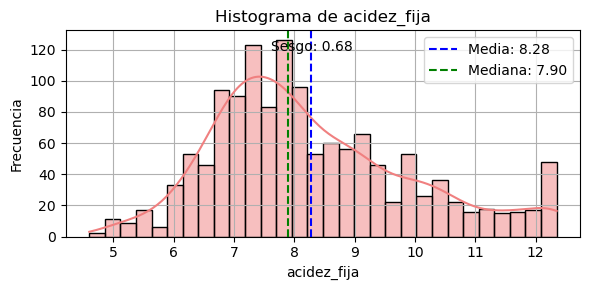

Análisis para la columna 'acidez_fija':
- Media: 8.28
- Mediana: 7.90
- Moda: 7.20
- Sesgo: 0.68
 -> Distribución sesgada a la derecha (asimetría positiva)
------------------------------------------------------------


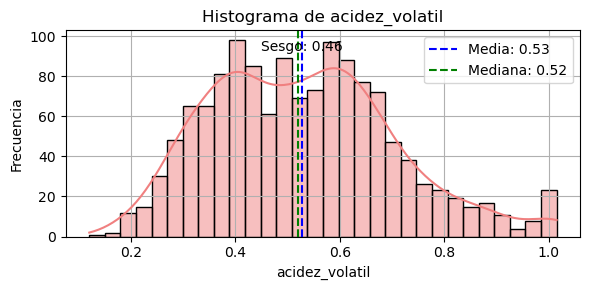

Análisis para la columna 'acidez_volatil':
- Media: 0.53
- Mediana: 0.52
- Moda: 0.50
- Sesgo: 0.46
Distribución aproximadamente simétrica
------------------------------------------------------------


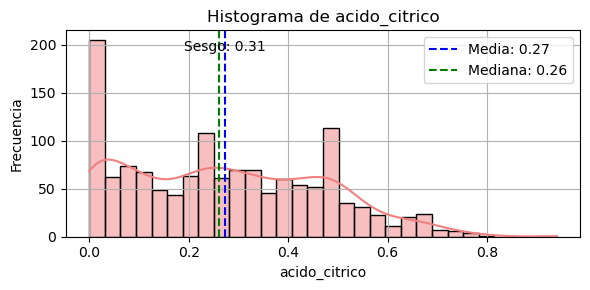

Análisis para la columna 'acido_citrico':
- Media: 0.27
- Mediana: 0.26
- Moda: 0.00
- Sesgo: 0.31
Distribución aproximadamente simétrica
------------------------------------------------------------


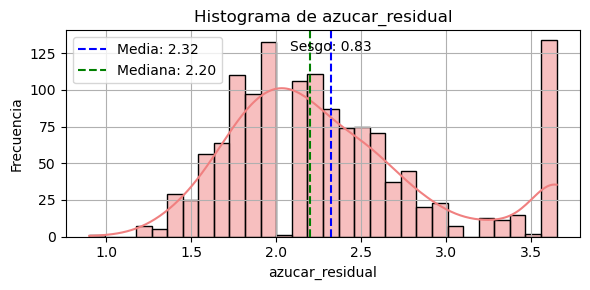

Análisis para la columna 'azucar_residual':
- Media: 2.32
- Mediana: 2.20
- Moda: 2.00
- Sesgo: 0.83
 -> Distribución sesgada a la derecha (asimetría positiva)
------------------------------------------------------------


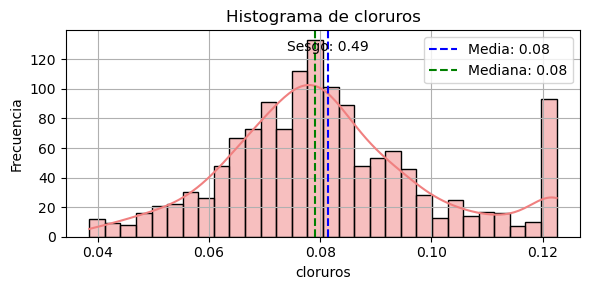

Análisis para la columna 'cloruros':
- Media: 0.08
- Mediana: 0.08
- Moda: 0.12
- Sesgo: 0.49
Distribución aproximadamente simétrica
------------------------------------------------------------


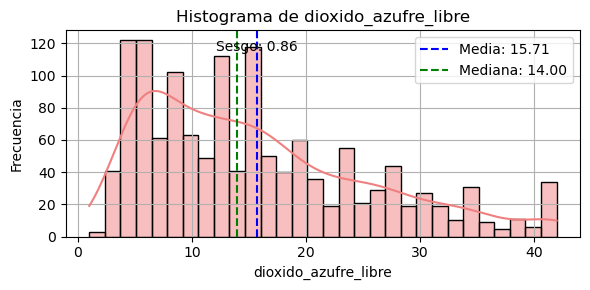

Análisis para la columna 'dioxido_azufre_libre':
- Media: 15.71
- Mediana: 14.00
- Moda: 6.00
- Sesgo: 0.86
 -> Distribución sesgada a la derecha (asimetría positiva)
------------------------------------------------------------


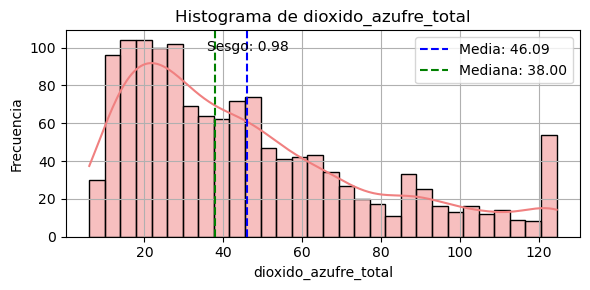

Análisis para la columna 'dioxido_azufre_total':
- Media: 46.09
- Mediana: 38.00
- Moda: 124.50
- Sesgo: 0.98
 -> Distribución sesgada a la derecha (asimetría positiva)
------------------------------------------------------------


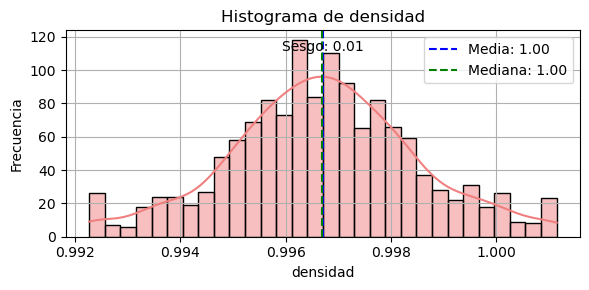

Análisis para la columna 'densidad':
- Media: 1.00
- Mediana: 1.00
- Moda: 1.00
- Sesgo: 0.01
Distribución aproximadamente simétrica
------------------------------------------------------------


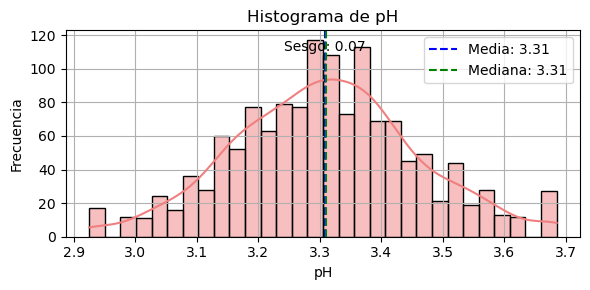

Análisis para la columna 'pH':
- Media: 3.31
- Mediana: 3.31
- Moda: 3.30
- Sesgo: 0.07
Distribución aproximadamente simétrica
------------------------------------------------------------


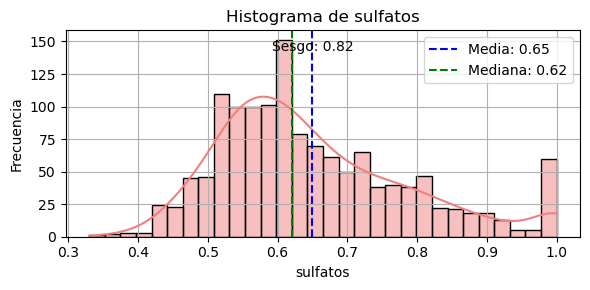

Análisis para la columna 'sulfatos':
- Media: 0.65
- Mediana: 0.62
- Moda: 0.54
- Sesgo: 0.82
 -> Distribución sesgada a la derecha (asimetría positiva)
------------------------------------------------------------


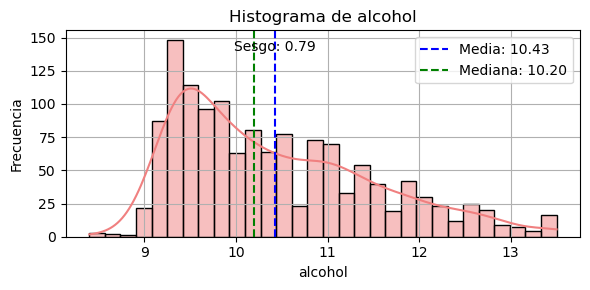

Análisis para la columna 'alcohol':
- Media: 10.43
- Mediana: 10.20
- Moda: 9.50
- Sesgo: 0.79
 -> Distribución sesgada a la derecha (asimetría positiva)
------------------------------------------------------------


In [177]:
# Seleccionamos solo las columnas deseadas
columnas_deseadas = ["acidez_fija", "acidez_volatil", "acido_citrico", "azucar_residual","cloruros", "dioxido_azufre_libre", "dioxido_azufre_total","densidad", "pH", "sulfatos", "alcohol"]

# Creamos el DataFrame numericas con solo esas columnas
numericas_deseada = numericas[columnas_deseadas]

# generamos un bucle for para crear los digramas
for col in numericas_deseada.columns:
    plt.figure(figsize=(6, 3)) # generamos graficas con 6 pulgadas de alto y 3 de ancho
    
    # Histograma con densidad de  15 columnas
    sns.histplot(numericas_deseada[col], bins=30, kde=True, color='lightcoral', edgecolor='black')
    
    # Calcularemos las variables estadísticas
    media = numericas_deseada[col].mean()
    mediana = numericas_deseada[col].median()
    sesgo = numericas_deseada[col].skew()
    moda = numericas_deseada[col].mode()[0]
   
    
    # agregamos líneas de media y mediana a la grafica
    plt.axvline(media, color='blue', linestyle='dashed', linewidth=1.5, label=f'Media: {media:.2f}')
    plt.axvline(mediana, color='green', linestyle='dashed', linewidth=1.5, label=f'Mediana: {mediana:.2f}')
    
    # colocamos Texto del sesgo
    plt.text(x=media, 
             y=plt.ylim()[1]*0.9, 
             s=f'Sesgo: {sesgo:.2f}', 
             color='black', 
             fontsize=10, 
             ha='center')
    
    # colocamos Títulos y etiquetas
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # imprimimos el Análisis
    print(f"Análisis para la columna '{col}':")
    print(f"- Media: {media:.2f}")
    print(f"- Mediana: {mediana:.2f}")
    print(f"- Moda: {moda:.2f}")
    print(f"- Sesgo: {sesgo:.2f}")

    if sesgo > 0.5:
        print(" -> Distribución sesgada a la derecha (asimetría positiva)")
    elif sesgo < -0.5:
        print("<- Distribución sesgada a la izquierda (asimetría negativa)")
    else:
        print("Distribución aproximadamente simétrica")
    print("-" * 60)

##### vamos a crear un gráfico de barras que nos permite comparar la cantidad de vinos buenos vs malos.

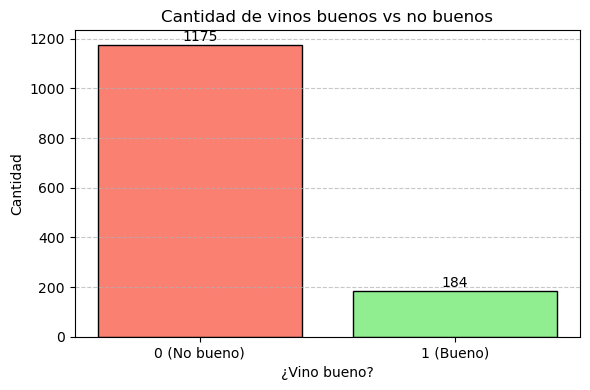

[0 1]


In [180]:

# Contamos los valores y los ordenamos: 0 (No bueno), 1 (Bueno)
conteo = numericas['vino_bueno_int'].value_counts()
conteo = conteo.reindex([0, 1]).fillna(0).astype(int)

# Creamos el gráfico de barras
plt.figure(figsize=(6, 4))
bars = plt.bar(conteo.index.astype(str), conteo.values, color=['salmon', 'lightgreen'], edgecolor='black')

# Colocamos Título y etiquetas
plt.title("Cantidad de vinos buenos vs no buenos")
plt.xlabel("¿Vino bueno?")
plt.ylabel("Cantidad")
plt.xticks(ticks=[0, 1], labels=["0 (No bueno)", "1 (Bueno)"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregamos el valor de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(numericas['vino_bueno_int'].unique())

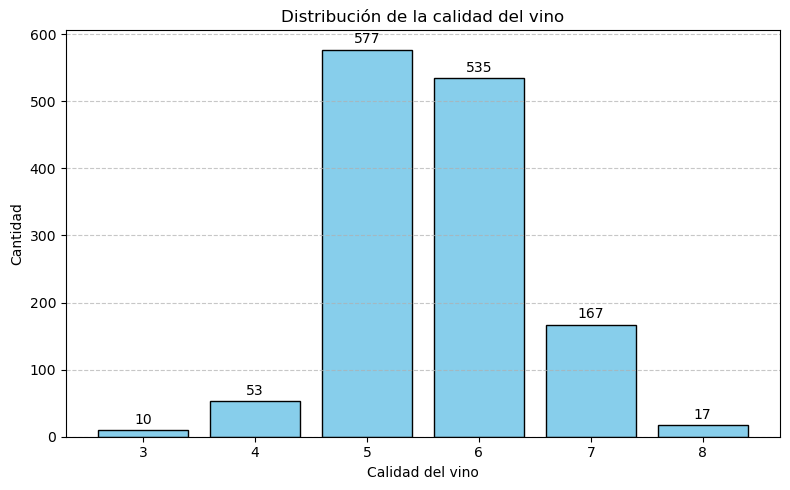

In [182]:
# Contamos cuántos vinos hay por cada nivel de calidad
conteo = numericas['calidad'].value_counts().sort_index()

# Creamos el gráfico de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(conteo.index.astype(str), conteo.values, color='skyblue', edgecolor='black')

# agregamos el Título y etiquetas
plt.title("Distribución de la calidad del vino")
plt.xlabel("Calidad del vino")
plt.ylabel("Cantidad")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostramos los valores encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

las graficas nos indican que solo alrededor del 13.5% de los vinos se consideran buenos, mientras que el 86.5% no lo son. Esto indica que los criterios de calidad son exigentes y que solo una pequeña fracción de los vinos logra ser clasificada como de buena calidad.

#### verificaremos mediante graficos de caja si existen valores atipicos

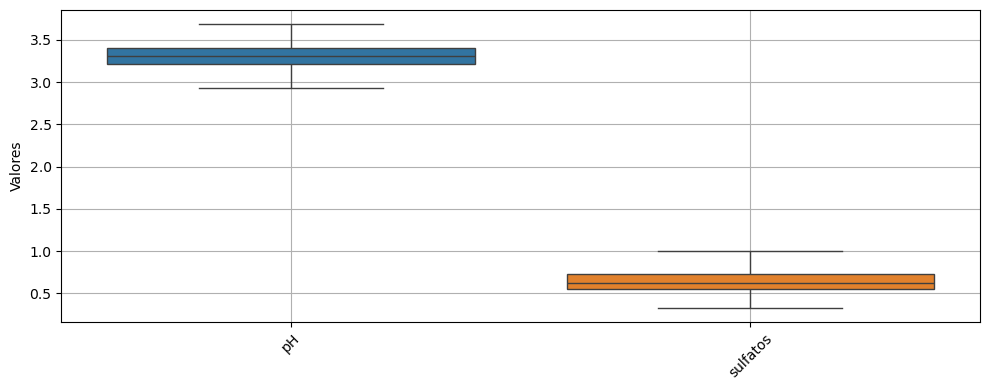

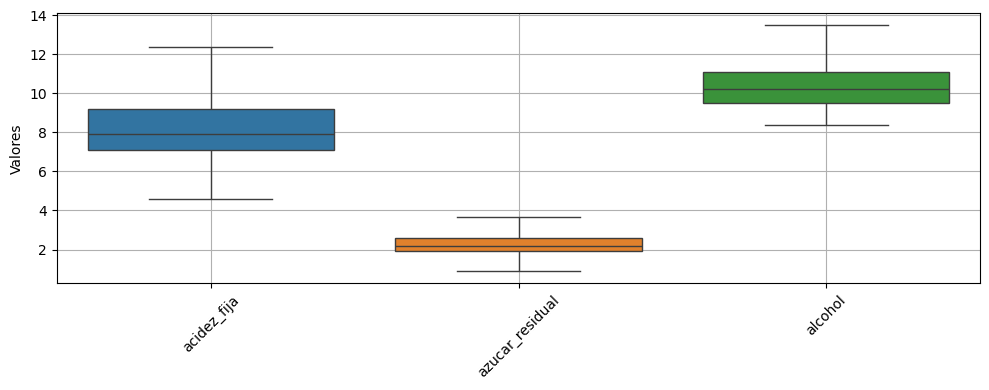

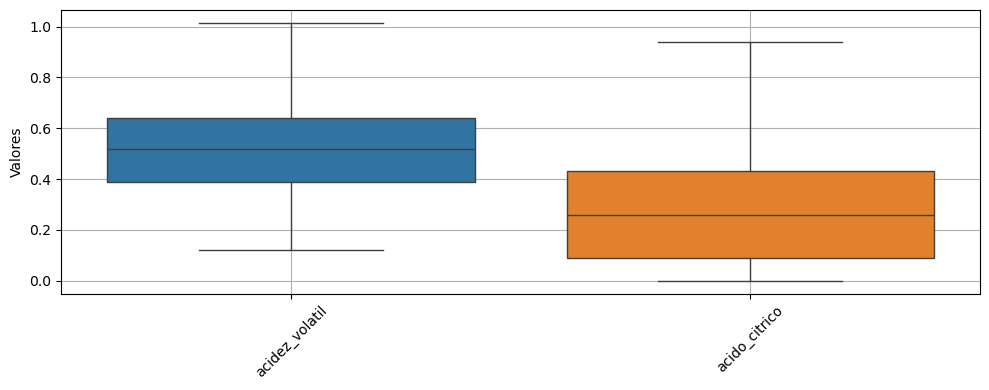

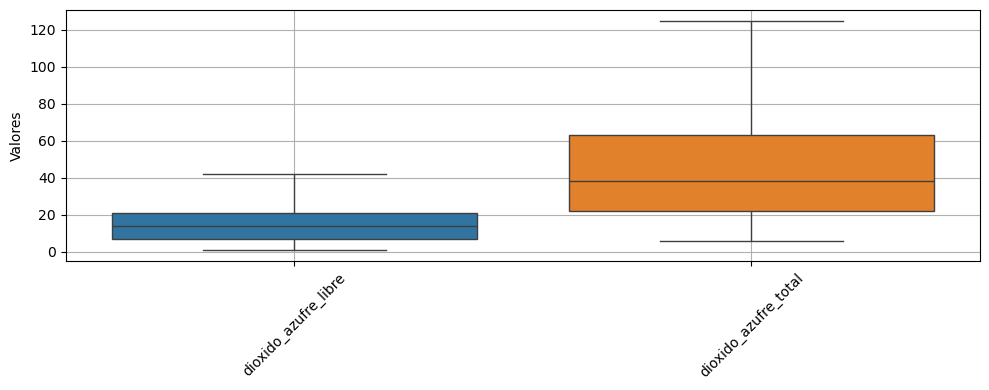

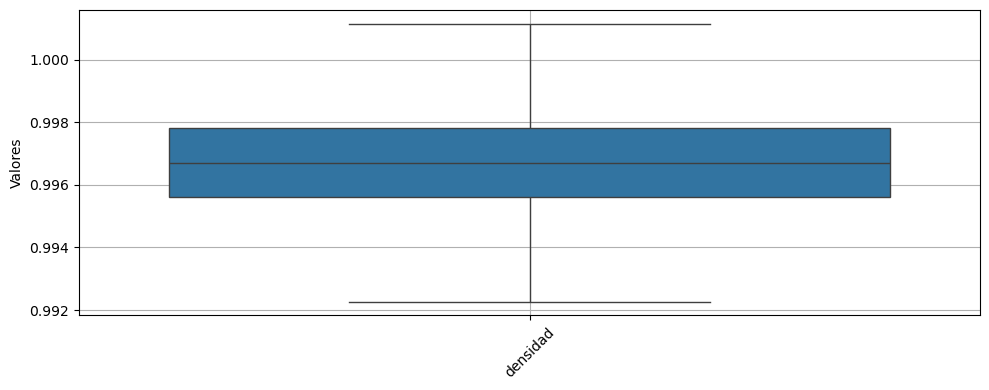

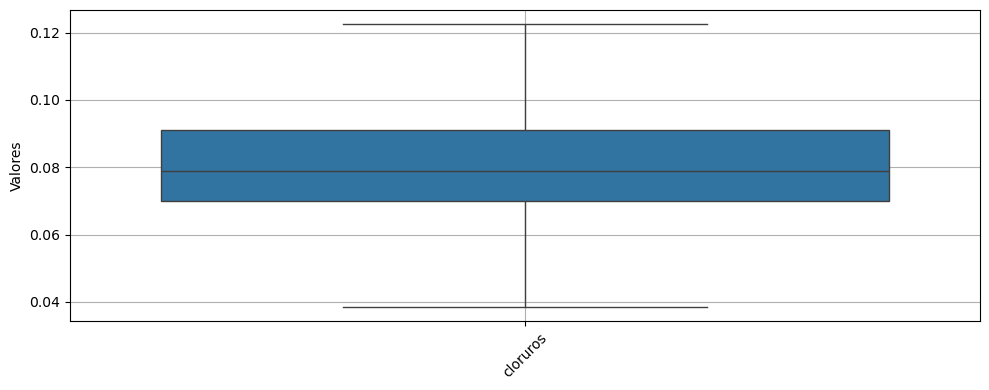

In [195]:


primeras_columnas = ["pH","sulfatos"]
segunda_columnas = ["acidez_fija","azucar_residual","alcohol"]
tercera_columnas = ["acidez_volatil","acido_citrico"]
cuarta_columnas =["dioxido_azufre_libre","dioxido_azufre_total"]
quinta_columnas =["densidad"]
sextas_columnas =["cloruros"]

ancho=4
alto=10


#primer diagrama 
plt.figure(figsize=(alto, ancho))
sns.boxplot(data=numericas[primeras_columnas])
plt.xticks(rotation=45)
plt.title('')
plt.ylabel('Valores')
plt.grid(True)
plt.tight_layout()
plt.show()

#segundo diagrama 
plt.figure(figsize=(alto, ancho))
sns.boxplot(data=numericas[segunda_columnas])
plt.xticks(rotation=45)
plt.title('')
plt.ylabel('Valores')
plt.grid(True)
plt.tight_layout()
plt.show()

#tercer diagrama 
plt.figure(figsize=(alto, ancho))
sns.boxplot(data=numericas[tercera_columnas])
plt.xticks(rotation=45)
plt.title('')
plt.ylabel('Valores')
plt.grid(True)
plt.tight_layout()
plt.show()

#cuarta diagrama 
plt.figure(figsize=(alto, ancho))
sns.boxplot(data=numericas[cuarta_columnas])
plt.xticks(rotation=45)
plt.title('')
plt.ylabel('Valores')
plt.grid(True)
plt.tight_layout()
plt.show()

#quinto diagrama 
plt.figure(figsize=(alto, ancho))
sns.boxplot(data=numericas[quinta_columnas])
plt.xticks(rotation=45)
plt.title('')
plt.ylabel('Valores')
plt.grid(True)
plt.tight_layout()
plt.show()

#sexto diagrama 
plt.figure(figsize=(alto, ancho))
sns.boxplot(data=numericas[sextas_columnas])
plt.xticks(rotation=45)
plt.title('')
plt.ylabel('Valores')
plt.grid(True)
plt.tight_layout()
plt.show()


#### vamos a hacer las correlacion

In [188]:
#separamos las columnas que necesitamos
predictors_col = ["acidez_fija","acidez_volatil","acido_citrico","azucar_residual","cloruros","dioxido_azufre_libre","dioxido_azufre_total","densidad","pH","sulfatos","alcohol"]
target_col = ["vino_bueno_int"]

predictors = numericas[predictors_col]
target = numericas[target_col]


hacemos la correlacion 

In [191]:
corr = predictors.corr()
corr

,acidez_fija,acidez_volatil,acido_citrico,azucar_residual,cloruros,dioxido_azufre_libre,dioxido_azufre_total,densidad,pH,sulfatos,alcohol
acidez_fija,1.000000,-0.267421,0.672454,0.214733,0.218094,-0.142253,-0.109957,0.669601,-0.693462,0.224572,-0.071651
acidez_volatil,-0.267421,1.000000,-0.560157,0.038673,0.141735,-0.012927,0.088597,0.021525,0.248465,-0.311123,-0.205689
acido_citrico,0.672454,-0.560157,1.000000,0.179259,0.147204,-0.047500,0.030291,0.361570,-0.555134,0.345605,0.106349
azucar_residual,0.214733,0.038673,0.179259,1.000000,0.196879,0.080342,0.152674,0.409174,-0.097583,0.018561,0.109226
cloruros,0.218094,0.141735,0.147204,0.196879,1.000000,-0.007580,0.107389,0.404969,-0.264409,0.127595,-0.306170
dioxido_azufre_libre,-0.142253,-0.012927,-0.047500,0.080342,-0.007580,1.000000,0.685832,-0.024608,0.059621,0.049309,-0.081324
dioxido_azufre_total,-0.109957,0.088597,0.030291,0.152674,0.107389,0.685832,1.000000,0.103915,-0.066471,-0.005515,-0.244589
densidad,0.669601,0.021525,0.361570,0.409174,0.404969,-0.024608,0.103915,1.000000,-0.347814,0.157616,-0.508409
pH,-0.693462,0.248465,-0.555134,-0.097583,-0.264409,0.059621,-0.066471,-0.347814,1.000000,-0.154669,0.202165
sulfatos,0.224572,-0.311123,0.345605,0.018561,0.127595,0.049309,-0.005515,0.157616,-0.154669,1.000000,0.157635


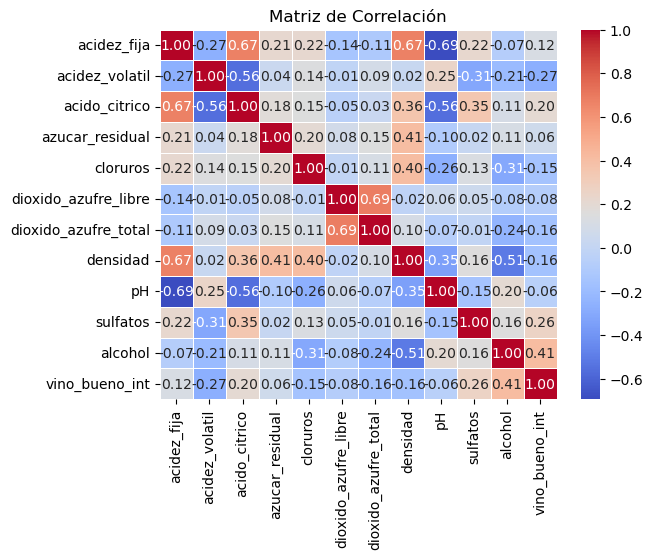

In [295]:
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()


Se observa una alta correlación positiva entre la acidez fija y el ácido cítrico, lo que indica que estos dos componentes tienden a aumentar o disminuir juntos. Asimismo, la densidad muestra una relación directa con la acidez fija y una relación inversa con el alcohol, coherente con el hecho de que un mayor contenido alcohólico suele reducir la densidad del vino. 

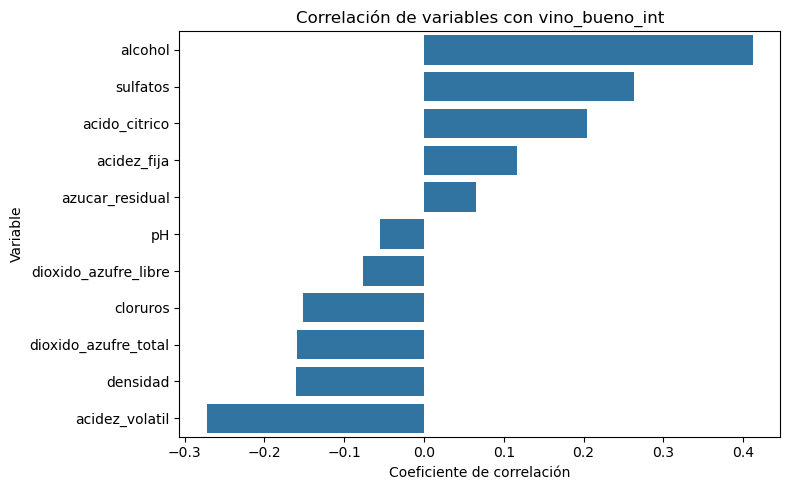

In [299]:
# --- Correlaciones con vino_bueno_int ---
correlaciones = numericas.corr()['vino_bueno_int'].drop(['vino_bueno_int', 'calidad'])
correlaciones.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(8, 5))
sns.barplot(x=correlaciones.values, y=correlaciones.index)  # Warning, pero funciona bien
plt.title("Correlación de variables con vino_bueno_int")
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()




En este gráfico se presenta la correlación de cada variable con la variable binaria que representa si un vino es considerado bueno o no. El alcohol destaca como la variable más correlacionada positivamente con la calidad del vino, seguido por los sulfitos y el ácido cítrico. Por otro lado, la acidez volátil muestra una correlación negativa significativa, indicando que altos niveles de esta variable tienden a relacionarse con vinos de menor calidad.

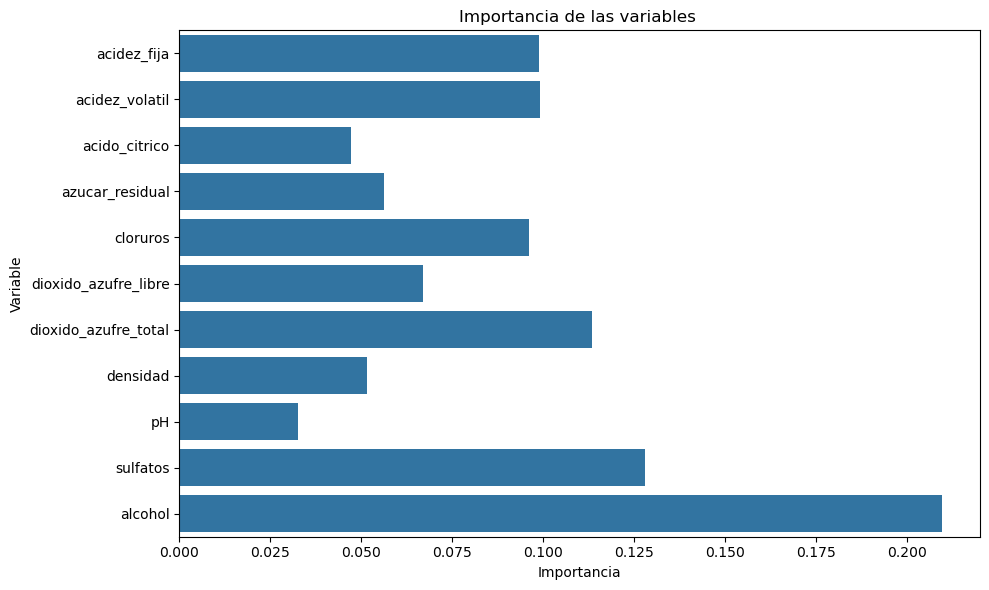

In [303]:

# --- Importancia de las variables ---
importancias = modelo.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importancias, y=features)
plt.title("Importancia de las variables ")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


muestra la importancia relativa de cada variable dentro de un modelo predictivo, el alcohol vuelve a posicionarse como la característica más relevante para predecir si un vino será considerado de buena calidad. Le siguen los sulfatos, el dióxido de azufre total, la acidez fija, la acidez volátil y los cloruros.

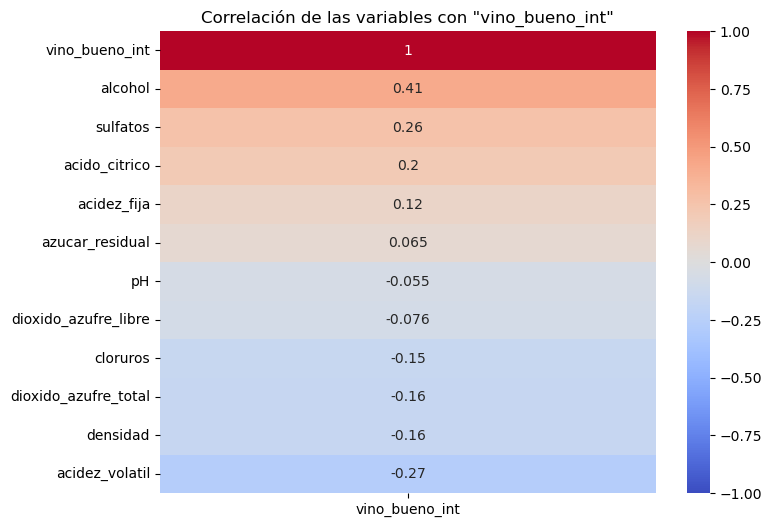

In [305]:

# Seleccionamos solo las columnas relevantes (predictoras + target)
predictors_col = ["acidez_fija", "acidez_volatil", "acido_citrico", "azucar_residual",
                  "cloruros", "dioxido_azufre_libre", "dioxido_azufre_total",
                  "densidad", "pH", "sulfatos", "alcohol", "vino_bueno_int"]

# Creamos un nuevo DataFrame solo con esas columnas
corr_data = numericas[predictors_col]

# Calculamos la matriz de correlación
corr = corr_data.corr()

# Mostramos solo la correlación con el target
corr_target = corr[["vino_bueno_int"]].sort_values(by="vino_bueno_int", ascending=False)

# Graficamos
plt.figure(figsize=(8, 6))
sns.heatmap(corr_target, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlación de las variables con "vino_bueno_int"')
plt.show()


El color más oscuro para el alcohol indica su fuerte correlación positiva con la calidad del vino, mientras que el tono más claro para la acidez volátil refleja su impacto negativo. Aunque la mayoría de las variables muestran correlaciones débiles, esta representación gráfica permite detectar rápidamente aquellas que pueden tener una influencia directa 

#### vamos a entrenar los datos

usaremos un porcentaje de datos para entrenamiento (train) = 75% , y para prueba (test) = 25%

[Text(0.5463299418604651, 0.9705882352941176, 'x[10] <= 11.55\ngini = 0.226\nsamples = 1019\nvalue = [887, 132]'),
 Text(0.28015988372093026, 0.9117647058823529, 'x[1] <= 0.335\ngini = 0.142\nsamples = 857\nvalue = [791, 66]'),
 Text(0.4132449127906977, 0.9411764705882353, 'True  '),
 Text(0.13662790697674418, 0.8529411764705882, 'x[9] <= 0.735\ngini = 0.447\nsamples = 98\nvalue = [65, 33]'),
 Text(0.08139534883720931, 0.7941176470588235, 'x[0] <= 11.6\ngini = 0.295\nsamples = 50\nvalue = [41, 9]'),
 Text(0.05813953488372093, 0.7352941176470589, 'x[8] <= 3.395\ngini = 0.201\nsamples = 44\nvalue = [39, 5]'),
 Text(0.046511627906976744, 0.6764705882352942, 'x[6] <= 10.5\ngini = 0.133\nsamples = 42\nvalue = [39, 3]'),
 Text(0.023255813953488372, 0.6176470588235294, 'x[2] <= 0.43\ngini = 0.48\nsamples = 5\nvalue = [3, 2]'),
 Text(0.011627906976744186, 0.5588235294117647, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.03488372093023256, 0.5588235294117647, 'gini = 0.0\nsamples = 3\nval

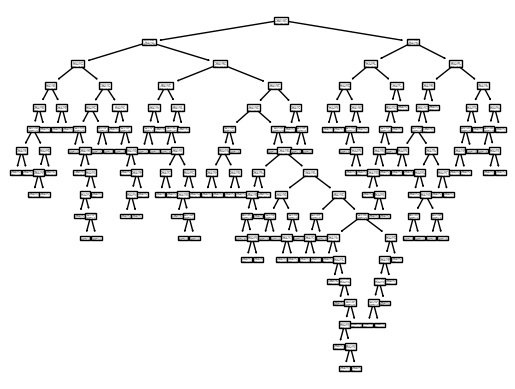

In [227]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.25, random_state=40)
tree = DecisionTreeClassifier()
arbol = tree.fit(X_train, y_train)
plot_tree(arbol)

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       288
           1       0.43      0.38      0.40        52

    accuracy                           0.83       340
   macro avg       0.66      0.65      0.65       340
weighted avg       0.82      0.83      0.82       340



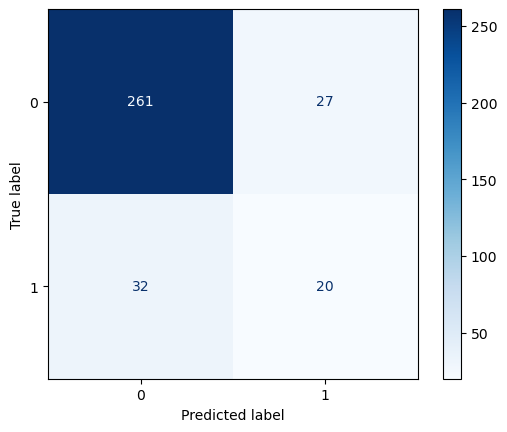

In [281]:

cm=confusion_matrix(y_test, y_pred)
disp=metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Cambié el color a 'viridis'
#disp.plot()

# Predicción con el set de prueba
y_pred = arbol.predict(X_test)

# Reporte detallado (precision, recall, f1-score)
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))

1. Para la clase 0 (vinos no buenos), el modelo presenta métricas sólidas: una precisión del 89%, recall del 91% y F1-score del 90%, lo que indica que identifica correctamente la mayoría de los vinos no buenos.
2. para la clase 1 (vinos buenos), el rendimiento es mucho menor, con una precisión del 43%, un recall del 38% y un F1-score del 40%.
3. en la matriz de confusión: de los 52 vinos buenos, solo 20 fueron clasificados correctamente, mientras que 32 fueron erróneamente identificados como no buenos.

Esto sugiere que el árbol de decisión está sesgado hacia la clase 0, probablemente debido al desbalance en los datos teniendo en cuenta que solo un 13.5% de los vinos son buenos es decir 184 mientras que 1175 no son buenos , lo que hace que el modelo aprenda a predecir “malo” casi todo el tiempo para tener una alta exactitud general , esto hace que le cuesta mucho predecir correctamente los vinos buenos (clase 1), porque casi no ha visto ejemplos de ellos